# Scenario
I work as a data analyst at a motorcycle shop in Tokyo. One day, we held a board meeting with the agenda of “boosting sales”. The data analytics team quickly identified 95% customers hesitate to sign for new motorcycles because of low trade-in offers. Our conclusion was clear, reinforcing the trade-in program would be the solution. Therefore, accurately predicting used motorcycle price will be a key to our successful business. However we didn't have a data science team for making prediction model at the time. We promptly formed one, and I was assigned to lead it.

***This case study follows the steps below:***

> 1. Data Collection
> 2. Data Cleaning and Preprocessing
> 3. Data Exploring
> 4. Feature Engineering
> 5. Model Selection, Tuning and Evaluation
> 6. Deployment



# 1. Data Collection

Fortunately, one of our business partners, a motorcycle exporter, provided historical data of motorcycle auction but its format is HTML. To retrieve the entire data, I need to use a Python scraping program.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Create an empty list to store the rows from all pages
all_rows = []

# Loop through all the pages
for page_num in range(1, 80):
    # Send a request to the website
    url = f'https://www.motobay.su/brands/1/models/1038?page={page_num}'
    response = requests.get(url)

    # Use BeautifulSoup to parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table containing the motorcycle data
    table = soup.find('table')

    # Extract the table rows
    rows = []
    for tr in table.find_all('tr')[1:]:
        row = []
        for td in tr.find_all('td'):
            row.append(td.text.strip())
        rows.append(row)

    # Add the rows to the list of all rows
    all_rows += rows

# Create a pandas DataFrame from the table data
df = pd.DataFrame(all_rows)

# Save the DataFrame to csv
df.to_csv('motorcycle_data.csv', index=False)

# Preview of the dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,,1390JBA YOKOHAMA,10 ноября 2023,YamahaSR400,1995,400,1JR1JR-321032,24 511,3,164 000 ¥0 ¥,SOLD,"черный, зеленый",289 600 р.*307 600 р.*6410 NZD*
1,,2551BDS KYUSHU,10 ноября 2023,YamahaSR400 Gen.2,1997,400,1JR1JR-335103,5 725,4,246 000 ¥0 ¥,SOLD,"белый, черный",345 200 р.*363 200 р.*7540 NZD*
2,,5376BDS KANSAI\r\n ...,10 ноября 2023,YamahaSR400 Gen.4,2018,400,RH03JRH03J-009269,10 617,4,440 000 ¥100 000 ¥,SOLD,черный,541 400 р.*559 400 р.*10220 NZD*
3,,7051JBA YOKOHAMA,10 ноября 2023,YamahaSR400,2000,400,1JR1JR-343552,3 445,3,344 000 ¥220 000 ¥,SOLD,зеленый,411 800 р.*429 800 р.*8900 NZD*
4,,7073JBA YOKOHAMA,10 ноября 2023,YamahaSR400,1988,400,1JR1JR-263631,17 791,3,192 000 ¥120 000 ¥,SOLD,серый,308 600 р.*326 600 р.*6800 NZD*


# 2. Data Cleaning and Preprocessing

## Data Cleaning
Due to inconsistencies in the original dataset, data cleaning and preprocessing are required for better data analysis. Additionally, to determine how to process the dataset, it is important to understand its structure. These are the reasons why I developed three useful functions,

* Data Cleaning Function
* Data Summaring Function
* Variation Checking Function

In [2]:
# Install required library
!pip install dateparser

# Hide warning messages 
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 4.4 MB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
import dateparser

# Loading dataset
df = pd.read_csv('/kaggle/input/sr400-auction-data/motorcycle_data_20230810.csv')

# Data Cleaning Function
def data_cleaning(df):
    # Deleting unnecessary columns and labelling attributes
    df.drop(columns=['0', '3', '5', '10', '12'], inplace=True)
    df.columns = ['raw_location', 'date', 'production', 'frame', 'travel', 'rate', 'raw_prices', 'raw_colour']

    # 'location' Abstracting necessary strings from texts divided by spaces
    locations = df.raw_location.str.split(expand=True)
    locations.columns = ['del1', 'location', 'del2']
    df = pd.concat([df, locations], axis=1)
    df.drop(columns=['raw_location', 'del1', 'del2'], axis=1, inplace=True)
    df.location = df.location.str.replace('関西', 'KANSAI') 

    # 'date' Translating and transforming to data type "date"
    df.date = df.date.str.replace(r'\d+:\d+', '')
    df.date = df.date.apply(dateparser.parse)

    # 'travel' Trimming unnecessary spaces
    df.travel = df.travel.str.replace(' ', '') 

    # 'raw_prices' Splitting connected 2 price data into 'Startprice' and 'price'
    df.raw_prices = df.raw_prices.str.replace(' ', '') 
    pricedata = df.raw_prices.str.split('¥', expand=True)
    pricedata.columns = ['price', 'Startprice', 'del']
    df = pd.concat([df, pricedata], axis=1)
    df.drop(columns=['raw_prices', 'del'], axis=1, inplace=True)

    # 'raw_colour' Deleting unnecessary sub colours
    df.raw_colour = df.raw_colour.str.replace(' ', '') 
    colourdata = df.raw_colour.str.split(',', expand=True)
    colourdata.columns = ['colour', 'del']
    df = pd.concat([df, colourdata], axis=1)
    df.drop(columns=['raw_colour', 'del'], axis=1, inplace=True)

    # 'frame' Abstracting specific strings form connected texts
    df.frame = df.frame.apply(lambda x: '2H6' if x.startswith('2H6') else x)
    df.frame = df.frame.apply(lambda x: '1JR' if x.startswith('1JR') else x)
    df.frame = df.frame.apply(lambda x: 'RH01J' if x.startswith('RH01J') else x)
    df.frame = df.frame.apply(lambda x: 'RH03J' if x.startswith('RH03J') else x)
    df.frame = df.frame.apply(lambda x: 'RH16J' if x.startswith('RH16J') else x)
    frametypes = ['2H6', '1JR', 'RH01J', 'RH03J', 'RH16J']
    df = df[df.frame.isin(frametypes)]

    # 'rate' Replacing invalid value
    df.rate = df.rate.apply(lambda x: None if x == 'R' else x)
    
    # 'colour' Replacing invalid value
    df.colour = df.colour.apply(lambda x: None if x.endswith('色替') else x)

    return df

# Data Summarise Function
def summary(df):
    print("Data Preview:")
    print(df.head())
    print("\nData Shape:")
    print("Row, Column:", df.shape)
    print("\nMissing Values:")
    print(df.apply(lambda x: sum(x.isnull()), axis=0))

# Variation Cheaking Function    
def variation(df):    
    print("\nProduction:")
    print(df.production.unique())
    print("\nFrame:")
    print(df.frame.unique())
    print("\nRate:")
    print(df.rate.unique())     
    print("\nLocation:")
    print(df.location.unique()) 
    print("\nColour:")
    print(df.colour.unique())

clean_df = data_cleaning(df)
clean_df.to_csv('clean_motorcycle_data.csv', index=False)

summary(clean_df)
variation(clean_df)


Data Preview:
        date  production  frame travel rate location   price Startprice  \
0 2023-08-09      2008.0  RH01J  15480    5    KANTO  320000     200000   
1 2023-08-09      2006.0  RH01J  25457    4    KANTO  300000     150000   
2 2023-08-09      2021.0  RH16J   3277    7    KANTO  574000     370000   
3 2023-08-09      1995.0    1JR   9085    3    KANTO  312000     120000   
4 2023-08-09      2001.0  RH01J   1183    3    KANTO  314000          0   

        colour  
0      красный  
1       черный  
2  темно-синий  
3       черный  
4       черный  

Data Shape:
Row, Column: (1970, 9)

Missing Values:
date           0
production    22
frame          0
travel         1
rate          40
location       0
price          0
Startprice     0
colour        17
dtype: int64

Production:
[2008. 2006. 2021. 1995. 2001. 1999. 1992. 2002. 2005. 2007. 1994.   nan
 2017. 2003. 1985. 2012. 1998. 2004. 2018. 2011. 1984. 2015. 1996. 2009.
 2016. 1989. 1991. 1993. 1983. 1990. 1997. 2020. 2010. 

## Data Preprocessing 
After data cleaning, I noticed certain columns need further transformation.
* Data format conversion: 'date'
* Categorical data encoding: 'location', 'frame', 'colour'
* Missing values imputation: 'production', 'travel', 'rate'

In [4]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer

df = pd.read_csv('/kaggle/working/clean_motorcycle_data.csv')

# Data Preprocessing Function
def data_preprocessing(df):
    # Data format conversion
    df.date = df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timestamp())
    
    # Categorical data encoding
    objects = (df.dtypes == 'object')
    object_cols = list(objects[objects].index)
    OH_encoder = OneHotEncoder(sparse=False)
    OH_df = OH_encoder.fit_transform(df[object_cols])
    df = pd.concat([df.drop(object_cols, axis=1), pd.DataFrame(OH_df)], axis=1)

    # Missing values imputation
    my_imputer = SimpleImputer()
    imputed_df = pd.DataFrame(my_imputer.fit_transform(df))
    imputed_df.columns = df.columns
    
    return imputed_df

# Saving Dataframe and showing summary
preprocessed_df = data_preprocessing(df)
preprocessed_df.to_csv('preprocessed_data.csv', index=False)
summary(preprocessed_df)

Data Preview:
           date  production   travel  rate     price  Startprice    0    1  \
0  1.691539e+09      2008.0  15480.0   5.0  320000.0    200000.0  0.0  0.0   
1  1.691539e+09      2006.0  25457.0   4.0  300000.0    150000.0  0.0  0.0   
2  1.691539e+09      2021.0   3277.0   7.0  574000.0    370000.0  0.0  0.0   
3  1.691539e+09      1995.0   9085.0   3.0  312000.0    120000.0  1.0  0.0   
4  1.691539e+09      2001.0   1183.0   3.0  314000.0         0.0  0.0  0.0   

     2    3  ...   66   67   68   69   70   71   72   73   74   75  
0  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
2  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
3  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 82 columns]

Data Shape:
Row, Column: (1970, 82)

Missing Values:
date          0
production

# 3. Data Exploring

Before proceeding with feature engineering, I visualised the dataset to gain insights and inspiration.

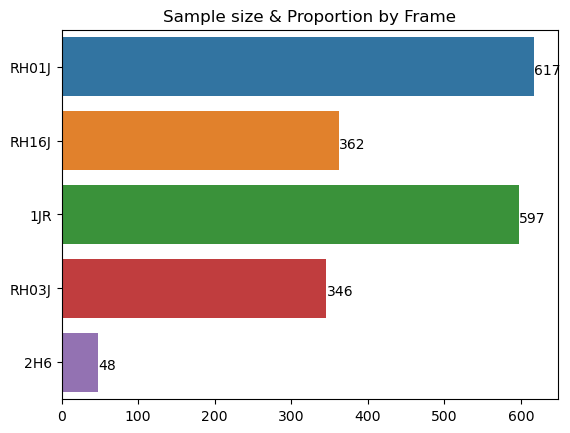

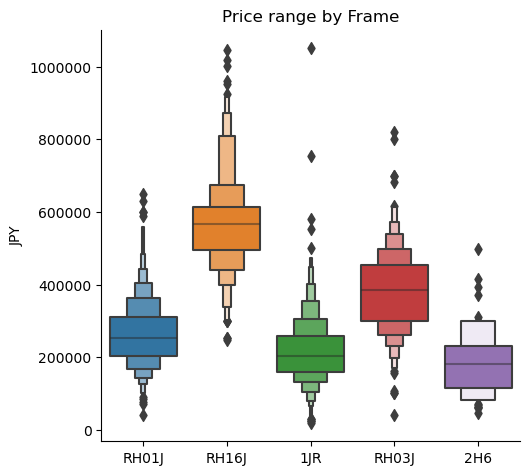

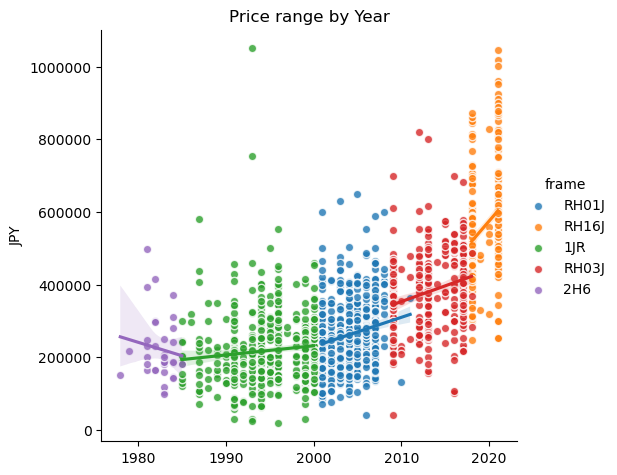

Travel and Price


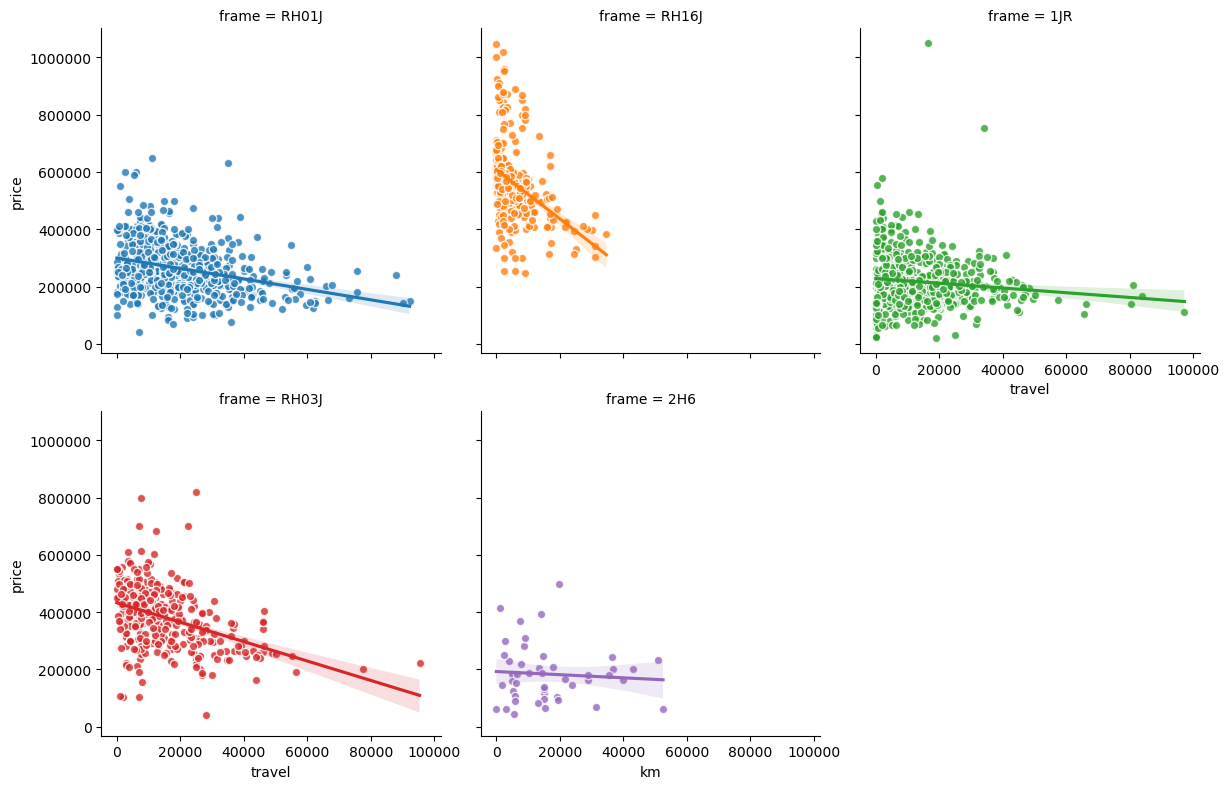

Condition rate and Price range


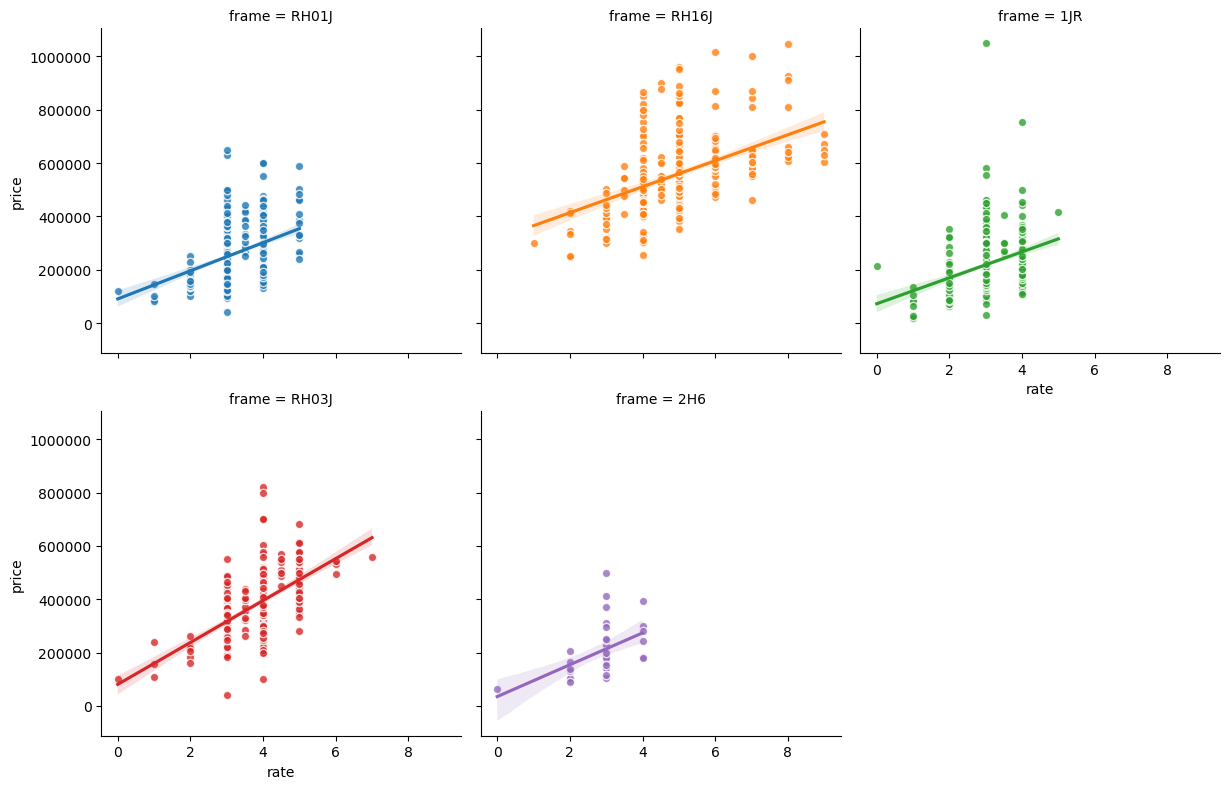


Production:
[2008. 2006. 2021. 1995. 2001. 1999. 1992. 2002. 2005. 2007. 1994.   nan
 2017. 2003. 1985. 2012. 1998. 2004. 2018. 2011. 1984. 2015. 1996. 2009.
 2016. 1989. 1991. 1993. 1983. 1990. 1997. 2020. 2010. 2013. 2019. 1986.
 2000. 2014. 1987. 1988. 1981. 1982. 1979. 1978.]

Frame:
['RH01J' 'RH16J' '1JR' 'RH03J' '2H6']

Rate:
['5' '4' '7' '3' '2' '6' '3.5' '4.5' '1' None '8' '0' '9']

Location:
['KANTO' 'KOBE' 'FUKUOKA' 'KYUSHU' 'KANSAI' 'YOKOHAMA' 'AICHI' 'OITA'
 'SAITAMA' 'TOCHIGI' 'OSAKA' 'SHIGA' 'HIROSHIMA' 'KUSHIRO' 'NIIGATA'
 'KANAGAWA' 'IBARAKI' 'SHIZUOKA' 'MIYAGI' 'NARA' 'SAPPORO' 'OKINAWA'
 'OBIHIRO' 'IWATE' 'ISHIKAWA' 'YAMANASHI' 'AOMORI' 'TOKYO' 'NAGASAKI'
 'KUMAMOTO' 'KITAMI' 'BAYSIDE' 'FUKUI' 'HYOGO' 'YAMAGUCHI' 'CHIBA'
 'SHIMANE' 'WAKAYAMA' 'NAGANO' 'FUKUSHIMA' 'ASAHIKAWA' 'ARAI' 'GUNMA'
 'Aucnet']

Colour:
['красный' 'черный' 'темно-синий' 'синий' 'серый' 'белый' 'зеленый'
 'серебристый' 'матовыйчерный' 'бордовый' 'коричневый' None 'желтый'
 'темно-бордовый' 'пурп

In [5]:
#Visualising the dataset

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/working/clean_motorcycle_data.csv')

ax = sns.countplot(y = df.frame, orient='h')
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width() + 0.2, p.get_y() + 0.5))
plt.xlabel('')
plt.ylabel('')
plt.title('Sample size & Proportion by Frame')
plt.show()
    
sns.catplot(x='frame', y='price', data=df, kind='boxen')
plt.xlabel('')
plt.ylabel('JPY')
plt.title('Price range by Frame')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

sns.lmplot(x='production', y='price', data=df, hue='frame',  scatter_kws={'edgecolor': 'w'})
#sns.scatterplot(x='production', y='price', data=X, hue='frame')
plt.title('Price range by Year')
plt.xlabel('')
plt.ylabel('JPY')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

print('Travel and Price')
sns.lmplot(x='travel', y='price', hue='frame', col='frame', data=df, 
           scatter_kws={'edgecolor': 'w'}, col_wrap=3, height=4)
plt.xlabel('km')
plt.ylabel('JPY')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

print('Condition rate and Price range')
sns.lmplot(x='rate', y='price', hue='frame', col='frame', data=df, 
           scatter_kws={'edgecolor': 'w'}, col_wrap=3, height=4)
plt.xlabel('')
plt.ylabel('JPY')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

variation(clean_df)


### Facts and Insights from data exploration:

>* The ‘frame’ feature is considered more important than the ‘location’ and ‘colour’ features due to their high cardinality.
>* As the manufacturing year of the models increases, their newness and lower travel distance become more highly valued.
>* This also means older models are less likely to be influenced by factors such as their travel distance or year of production.



### Setting a Baseline


In [6]:
# Setting a Baseline of Mean Absolute Error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('/kaggle/working/preprocessed_data.csv')

# Split data into train and validation
def split(df, test_size, random_state): 
    X = df.copy()
    y = X.pop('price')
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_valid, y_train, y_valid

# Random Forest Regressor Model
def RFR(model, data):
    X_train, X_valid, y_train, y_valid = data
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    mae = mean_absolute_error(predictions, y_valid)
    return int(mae)

model_RFR = RandomForestRegressor(n_estimators=120, random_state=0)

# Calculating a Baseline
Baseline = split(df, test_size=0.2, random_state=0)
MAE_1 = RFR(model_RFR, Baseline)
print('Baseline Model MAE: JPY', MAE_1)


Baseline Model MAE: JPY 44462


# 4. Feature Engineering
Based on the insights gained at the last phase, we decided to develop feature engineering focusing on ‘frame’. 
These are what we do.

* Removing outliers in the price and the production year range for each frame
* Missing value imputation grouped by frame

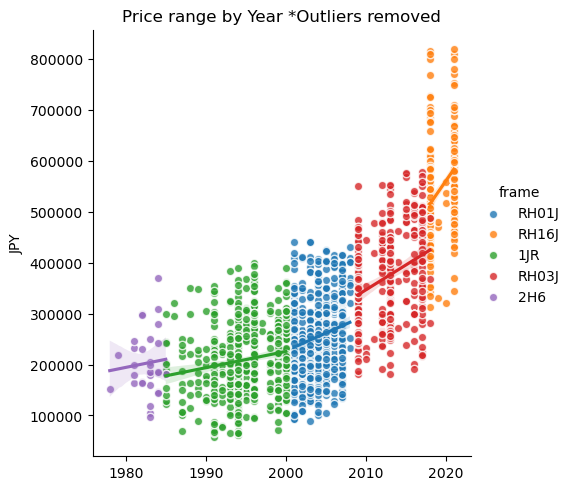

Feature Engineered Dataset MAE: JPY 38947


In [7]:
import numpy as np

df = pd.read_csv('/kaggle/working/clean_motorcycle_data.csv')

# Remove outliers lying out of 2 Standard deviations from the mean
Standard_deviation = df.groupby('frame')['price'].transform('std')
Threshold = 2
mask1 = np.abs(df['price'] - df.groupby('frame')['price'].transform('mean')) <= Threshold * Standard_deviation

# Remove outliers lying out of true production year
mask2 = ~((df['frame'] == 'RH01J') & (df['production'] > 2008))

# Execution
df = df[mask1 & mask2]

# Check the result
sns.lmplot(x='production', y='price', data=df, hue='frame',  scatter_kws={'edgecolor': 'w'})
#sns.scatterplot(x='production', y='price', data=X, hue='frame')
plt.title('Price range by Year *Outliers removed')
plt.xlabel('')
plt.ylabel('JPY')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

df.to_csv('clean_motorcycle_data_v2.csv', index=False)

df = data_preprocessing(df)
FEv1 = split(df, test_size=0.2, random_state=0)
MAE_FEv1 = RFR(model_RFR, FEv1)

print('Feature Engineered Dataset MAE: JPY', MAE_FEv1)


In [8]:
df = pd.read_csv('/kaggle/working/clean_motorcycle_data_v2.csv')
 
# Impute missing Travel values with Mean Travel, grouped by Frame
df.travel = df.groupby('frame')['travel'].transform(lambda x: x.fillna(x.mean()))

# Impute missing Rate values with Mean Rate, grouped by Frame
df.rate = df.groupby('frame')['rate'].transform(lambda x: x.fillna(x.mean()))

# Impute missing Production year values with Mean Production year, grouped by Frame
df.production = df.groupby('frame')['production'].transform(lambda x: x.fillna(x.mean()))

df.to_csv('clean_motorcycle_data_v3.csv', index=False)

df = data_preprocessing(df)
summary(df)

FEv2 = split(df, test_size=0.2, random_state=0)
MAE_FEv2 = RFR(model_RFR, FEv2)

print('Feature Engineered Dataset V2 MAE: JPY', MAE_FEv2)


Data Preview:
           date  production   travel  rate     price  Startprice    0    1  \
0  1.691539e+09      2008.0  15480.0   5.0  320000.0    200000.0  0.0  0.0   
1  1.691539e+09      2006.0  25457.0   4.0  300000.0    150000.0  0.0  0.0   
2  1.691539e+09      2021.0   3277.0   7.0  574000.0    370000.0  0.0  0.0   
3  1.691539e+09      1995.0   9085.0   3.0  312000.0    120000.0  1.0  0.0   
4  1.691539e+09      2001.0   1183.0   3.0  314000.0         0.0  0.0  0.0   

     2    3  ...   65   66   67   68   69   70   71   72   73   74  
0  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
2  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
3  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 81 columns]

Data Shape:
Row, Column: (1866, 81)

Missing Values:
date          0
production

# 5. Model Selection, Parameter tuning and Evaluation

## Model Selection
To improve prediction accuracy, I tried various models I have ever learned for prediction project.
>* Linear Regression
>* Random forest regression
>* XGBoost


In [9]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

df = pd.read_csv('/kaggle/working/clean_motorcycle_data_v3.csv')

def XGB(model, data):
    X_train, X_valid, y_train, y_valid = data
    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              verbose=False)
    predictions = model.predict(X_valid)
    mae = mean_absolute_error(predictions, y_valid)
    return int(mae)

def LNR(data):
    X_train, X_valid, y_train, y_valid = data
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    mae = mean_absolute_error(predictions, y_valid)
    return int(mae)



# Set models with parameters
model_XGB = XGBRegressor(n_estimators=120, learning_rate=0.12)
model_RFR = RandomForestRegressor(n_estimators=120, random_state=0)

#
MAE_1 = RFR(model_RFR, Baseline)
MAE_2 = RFR(model_RFR, FEv1)
MAE_3 = RFR(model_RFR, FEv2)
MAE_4 = XGB(model_XGB, Baseline)
MAE_5 = XGB(model_XGB, FEv1)
MAE_6 = XGB(model_XGB, FEv2)
MAE_7 = LNR(Baseline)
MAE_8 = LNR(FEv1)
MAE_9 = LNR(FEv2)

# Results
print("Dataset\nOriginal/ FEv1 / FEv2\n",
      MAE_1, "/", MAE_2, "/", MAE_3, " - Random Forest Regressor\n",
      MAE_4, "/", MAE_5, "/", MAE_6, " - XGBoost Regressor\n",
      MAE_7, "/", MAE_8, "/", MAE_9, " - Linear Regression\n")
      

Dataset
Original/ FEv1 / FEv2
 44462 / 38947 / 36952  - Random Forest Regressor
 45740 / 39860 / 39039  - XGBoost Regressor
 60630 / 93437 / 47139  - Linear Regression



Both Random Forest Regressor and XGBoost Regressor perform well with Feature Engineered Dataset Version 2, so far.
Parameter Tuning


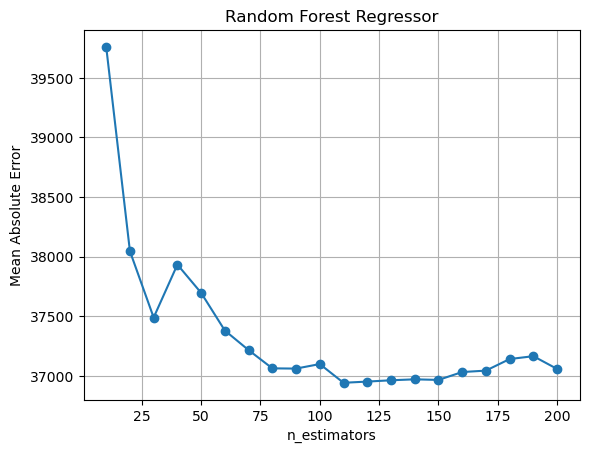

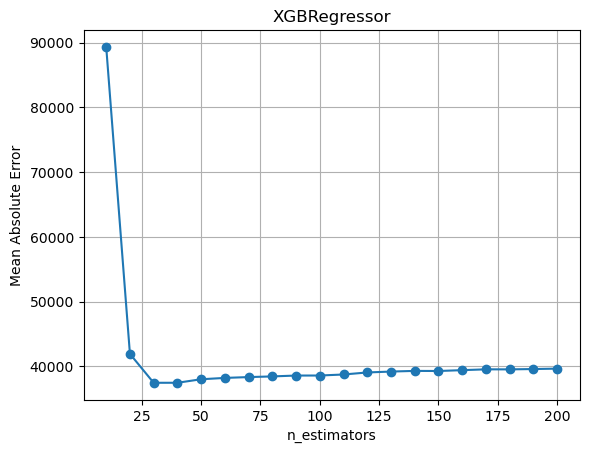

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define a list of n_estimators values
n_estimators_values = np.arange(10, 210, 10)

# Initialize an empty list to store the MAE values
mae_values = []

# Iterate over the n_estimators values
for n_estimators in n_estimators_values:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    mae = RFR(model, FEv2) 
    mae_values.append(mae)

# Plotting the results
plt.plot(n_estimators_values, mae_values, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest Regressor')
plt.grid(True)
plt.show()

# Reset a list to store the MAE values again
mae_values = []

# Iterate over the n_estimators values
for n_estimators in n_estimators_values:
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=0.12)
    mae = XGB(model, FEv2) 
    mae_values.append(mae)

# Plotting the results
plt.plot(n_estimators_values, mae_values, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Absolute Error')
plt.title('XGBRegressor')
plt.grid(True)
plt.show()

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Define a list of n_estimators values to try
n_estimators_values = np.arange(10, 210, 10)

# Initialize lists to store the mean MAE values for Random Forest and XGBoost
mae_rf_values = []
mae_xgb_values = []

for n_estimators in n_estimators_values:
    # Random Forest
    model_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    mae_rf = -np.mean(cross_val_score(model_rf, X, y, cv=5, scoring='neg_mean_absolute_error'))
    mae_rf_values.append(mae_rf)

    # XGBoost
    model_xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=0.12)
    mae_xgb = -np.mean(cross_val_score(model_xgb, X, y, cv=5, scoring='neg_mean_absolute_error'))
    mae_xgb_values.append(mae_xgb)

# Plotting the results for both models
plt.plot(n_estimators_values, mae_rf_values, label='Random Forest', marker='o')
plt.plot(n_estimators_values, mae_xgb_values, label='XGBoost', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'X' is not defined

In [ ]:
LR = np.arange(0.10, 0.31, 0.01)

# Reset a list to store the MAE values again
mae_values = []

# Iterate over the learning_rate values
for learning_rate in LR:
    model = XGBRegressor(n_estimators=110, learning_rate=learning_rate)
    mae = XGB(model, FEv2) 
    mae_values.append(mae)

# Plotting the results
plt.plot(LR, mae_values, marker='o')
plt.xlabel('learning_rate')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs. learning_rate')
plt.grid(True)
plt.show()

Evaluation

In [ ]:
from joblib import dump

Prediction_model = RandomForestRegressor(n_estimators=110, random_state=0)
RFR(Prediction_model, FEv2)

# Save the model to a file
joblib.dump(Prediction_model, 'Prediction_model.joblib')

# 6. Deployment
* Predict with unseen data
* Submit prediction



In [ ]:
# Create an empty list to store the rows from all pages
all_rows = []

# Loop through all the pages
for page_num in range(1, 10):
    # Send a request to the website
    url = f'https://www.motobay.su/brands/1/models/1038?page={page_num}'
    response = requests.get(url)

    # Use BeautifulSoup to parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table containing the motorcycle data
    table = soup.find('table')

    # Extract the table rows
    rows = []
    for tr in table.find_all('tr')[1:]:
        row = []
        for td in tr.find_all('td'):
            row.append(td.text.strip())
        rows.append(row)

    # Add the rows to the list of all rows
    all_rows += rows

# Create a pandas DataFrame from the table data
df = pd.DataFrame(all_rows)
 
print(df.head(), df.shape)

# Save the DataFrame to csv
df.to_csv('Unseen_data.csv', index=False)


In [ ]:
import pandas as pd 

# Read the data
unseen_data = pd.read_csv('/kaggle/input/unseen-data/Unseen_data.csv')

# Define a function detects columns contain missing value
def missing(unseen_data):
    return [col for col in df.columns if df[col].isnull().any()]

# Impute missing Travel values with Mean Travel, grouped by Frame
unseen_data.travel = unseen_data.groupby('frame')['travel'].transform(lambda x: x.fillna(x.mean()))

# Impute missing Rate values with Mean Rate, grouped by Frame
unseen_data.rate = unseen_data.groupby('frame')['rate'].transform(lambda x: x.fillna(x.mean()))

# Impute missing Production year values with Mean Production year, grouped by Frame
unseen_data.production = unseen_data.groupby('frame')['production'].transform(lambda x: x.fillna(x.mean()))

unseen_data = Data_Cleaning.fit_transform(unseen_data)
print(unseen_data.head())


In [ ]:
Baseline = split(unseen_data, test_size=0.2, random_state=0)

MAE_5 = RFR(model_RFR, )
MAE_6 = XGB(model_XGB, unseen_data)

# Results
print("Mean Absolute Error 1:", MAE_5)
print("Mean Absolute Error 2:", MAE_6)

In [ ]:
from xgboost import XGBRegressor

def XGB(model, data):
    X_train, X_valid, y_train, y_valid = data
    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              verbose=False)
    predictions = model.predict(X_valid)
    mae = mean_absolute_error(predictions, y_valid)
    return int(mae)

# Set n_estimators
NE=110

# Define models and data
model_XGB = XGBRegressor(n_estimators=NE, learning_rate=0.14, early_stopping_rounds=10)
model_RFR = RandomForestRegressor(n_estimators=NE, random_state=0)

# Train and evaluate the models using the helper function
MAE_5 = RFR(model_RFR, unseen_data)
MAE_6 = XGB(model_XGB, unseen_data)


# Results
print("Mean Absolute Error 1:", MAE_5)
print("Mean Absolute Error 2:", MAE_6)
